In [1]:
# import necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from PIL import Image

# PyTorch and TorchVision packages
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms

# autograding packages
import otter

In [2]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1" # give sane errors

In [192]:
grid_size=2

In [193]:
# https://pytorch.org/hub/pytorch_vision_mobilenet_v2/
allTransforms = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

In [194]:
from data_set import CampusImagesDataSet, normalize_point, denormalize_point

In [195]:
data = CampusImagesDataSet('data/train/processed', transform=allTransforms, grid_size=grid_size)
test_data = CampusImagesDataSet('data/test/processed', transform=allTransforms, grid_size=grid_size)
# raw_data = CampusImagesDataSet('data/train/raw')

In [196]:
data.grid_size

2

In [197]:
len(data)

225

In [198]:
data.image_one_hot_labels_freq

{0: 58, 3: 50, 2: 64, 1: 53}

In [199]:
test_data.image_one_hot_labels_freq

{0: 4, 1: 2, 2: 5, 3: 1}

In [200]:
data.get_real_location_grid()

[{'location': [40.44089126586914, -79.9481201171875], 'grid_location': '0,0'},
 {'location': [40.44089126586914, -79.94293975830078], 'grid_location': '0,1'},
 {'location': [40.44267272949219, -79.9481201171875], 'grid_location': '1,0'},
 {'location': [40.44267272949219, -79.94293975830078], 'grid_location': '1,1'}]

In [201]:
data[0][0]

tensor([[[ 0.9817,  0.9988,  1.0159,  ..., -0.3369,  0.2282,  0.5536],
         [ 0.9988,  1.0159,  1.0331,  ..., -1.1247, -0.5596,  0.0912],
         [ 1.0159,  1.0331,  1.0673,  ..., -1.5014, -1.2788, -0.5767],
         ...,
         [-1.1589, -1.1932, -1.1589,  ..., -0.2171, -0.1999, -0.1999],
         [-0.9705, -1.0733, -1.1075,  ..., -0.1999, -0.1828, -0.1657],
         [-1.0219, -1.1247, -1.2103,  ..., -0.2171, -0.2171, -0.2342]],

        [[ 1.2906,  1.3081,  1.3256,  ..., -0.2150,  0.3277,  0.6429],
         [ 1.3081,  1.3256,  1.3431,  ..., -1.0028, -0.4601,  0.2052],
         [ 1.3256,  1.3431,  1.3782,  ..., -1.3704, -1.1779, -0.4776],
         ...,
         [-1.1253, -1.1604, -1.1253,  ..., -0.0749, -0.0574, -0.0574],
         [-0.9328, -1.0378, -1.0728,  ..., -0.0399, -0.0224, -0.0224],
         [-0.9503, -1.0553, -1.1429,  ..., -0.0574, -0.0574, -0.0749]],

        [[ 1.7685,  1.7860,  1.8034,  ..., -0.0441,  0.4614,  0.7576],
         [ 1.7860,  1.8034,  1.8208,  ..., -0

In [202]:
label = data[0][1]
(label, data.label_to_real_location(label))

(tensor([1., 0., 0., 0.]), [40.44089126586914, -79.9481201171875])

In [203]:
from utils import plot_torch_image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


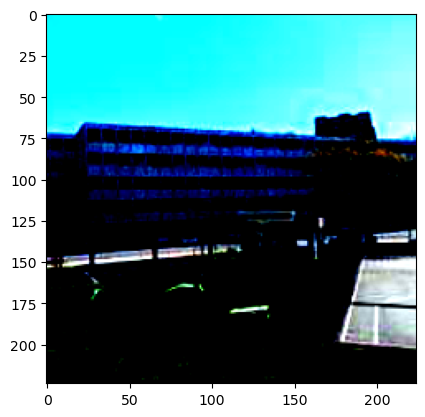

In [204]:
plot_torch_image(data[7][0])

In [205]:
img = data[3][0]

In [206]:
img.shape

torch.Size([3, 224, 224])

In [207]:
(np.average(img.numpy()), np.std(img.numpy()))

(-0.014028059, 0.8434023)

In [208]:
# [AG] defining the datasets, data-loaders, loss functions, and optimizers
def createTrainingUtils(model):
    '''Constructs the utilities that will be used to train the input model

    Note: if you initialize a PyTorch optimizer object with a specific model's parameters,
    then specific model's parameters will be updated during training. If your model is not training,
    it could be possible that you are optimizing the wrong set of parameters.

    Arguments:
        - model: a nn.Module object that will be trained and used to define the optimizer
    Returns:
        - trainDL: an nn.DataLoader object initialized with a training HotdogDataset, batch size of 16, and shuffling enabled
        - testDL: an nn.DataLoader object initialized with a testing HotdogDataset, batch size of 16, and shuffling enabled
        - lossfn: a binary-cross entropy loss object used for calculating the loss between predicted and target values
        - opt: an Adam optimizer initialized with model parameters and a learning rate of 0.001, all other values are default
    '''
    trainDL = DataLoader(CampusImagesDataSet('data/train/processed', transform=allTransforms, grid_size=grid_size), batch_size=16, shuffle=True)
    testDL = DataLoader(CampusImagesDataSet('data/test/processed', transform=allTransforms, grid_size=grid_size), batch_size=16, shuffle=True)
    lossfn = nn.CrossEntropyLoss()
    opt = torch.optim.Adam(model.parameters(), lr=0.001)
    return trainDL, testDL, lossfn, opt

In [209]:
class CMUGuesserNet(nn.Module):
    def __init__(self):
        '''Initializer for the MobileNet model to predict on the HotdogDataset

        1. load the mobilenet_v2 model (you will have to load weights depending on input pretrained)
        2. modify the final linear layer of the classifier to output 1 unit
        3. create a new final activation layer to turn the single output of the modified Mobilenet into a probability
            - we do this because MobileNet itself doesn't have any final activation layer
            - you will have to choose the appropriate activation for this last part

        Note: when loading the mobilenet model, set progress=False to avoid messing up the autograder

        Arguments:
            - pretrained: boolean indicating whether to use pre-trained weights on ImageNet (weights="MobileNet_V2_Weights.IMAGENET1K_V1")
                          or random weights but still using the model architecture (weights=None)
        '''
        super().__init__()
        # NOTE: store your adjusted, pre-trained mobilenet model object to the self.mobilenet attribute
        #       and your final activation layer to self.finalActivation
        #       as it will be used for autograding (note: you will have to use these in your forward function)
        mobilenet = torchvision.models.mobilenet_v2(weights=torchvision.models.MobileNet_V2_Weights.IMAGENET1K_V1)
        mobilenet.classifier[1]= nn.Sequential(
            nn.Linear(in_features=1280, out_features=grid_size * grid_size, bias=True),
        )
        # mobilenet.classifier[1]= nn.Linear(in_features=1280, out_features=2, bias=True)
        
        self.mobilenet = mobilenet
        self.finalActivation = nn.Softmax(dim=1)

    def forward(self, x):
        '''Computes the model's predictions given data x

        Note: because this model is a convolutional neural network and uses convolutional layers to process
        the input images into features, we can directly pass in images into the model instead of having to
        flatten the entire image into a single row vector like homework 3 which used an multi-layer perceptron (i.e. fully connected neural network)

        Don't forget to pass the mobilenet output through the appropriate activation!

        Arguments:
            - x: a (batch_size, 3, SIZE, SIZE) floating point tensor (note: SIZE defined at top of notebook)
        Returns:
            - yhat: a (batch_size, 1) floating point tensor containing predictions on whether the each image is not hotdog or hotdog
        '''
        x = self.mobilenet.forward(x)
        return self.finalActivation(x)

In [210]:
# DO NOT MODIFY THIS CELL BLOCK
def evalDL(model, dl, lossfn):

    # figure out if the GPU is available and send model and data to it
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # use torch.no_grad() context manager to prevent gradients from accumulating in evaluation
    # and hindering training
    with torch.no_grad():
        lossSum = 0
        nCorrect = 0
        for x, y in dl:
            x = x.to(device)
            y = y.to(device)
            

            yhat = model(x)

            # compute the loss and add to total (multiply by batch-size to make mean into sum)
            # by default, loss functions compute means of losses over batches
            lossSum += lossfn(yhat,y) * x.shape[0]

            # compute the number of correct and update
            predictions = torch.where(yhat > 0.5, 1, 0)
            truth = torch.where(y > 0.5, 1, 0)
            nCorrect += torch.sum(predictions == truth)

        numSamples = len(dl.dataset)
        avgLoss = lossSum / numSamples
        acc = nCorrect / numSamples
    return avgLoss.item(), acc.item()

def evaluate(model, trainDL, validDL, lossfn):
    trainLoss, trainAcc = evalDL(model, trainDL, lossfn)
    validLoss, validAcc = evalDL(model, validDL, lossfn)
    return trainLoss, trainAcc, validLoss, validAcc

In [211]:
def train(model, trainDL, validDL, lossfn, opt, epochs=10):
    '''Trains model and returns training and validation statistics

    Arguments:
        - model: nn.Module object whose parameters will be updated
        - trainDL: the nn.DataLoader object for the training dataset
        - validDL: the nn.DataLoader for the validation dataset
        - lossfn: a torch.nn loss function object used to evaluate how correct the model's predictions are
        - opt: a torch.optim.Optimizer object used for updating the model's parameters
        - epochs: the number of epochs to train for
    Returns:
        - model: the model after performing training and updating it's parameters
        - trainLosses: list s.t. trainLosses[i] = average loss on training dataset before epoch i
        - trainAccs: list s.t. trainAccs[i] = prediction accuracy on training dataset after epoch i
        - validLosses: list s.t. validLosses[i] = average loss on validation dataset after epoch i
        - validAccs: list s.t. validAccs[i] = prediction accuracy on validation dataset after epoch i
    '''

    trainLosses = []
    trainAccs   = []
    validLosses = []
    validAccs   = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # evaluate model without any training
    trainLoss, trainAcc, validLoss, validAcc = evaluate(model, trainDL, validDL, lossfn)
    trainLosses.append(trainLoss)
    trainAccs.append(trainAcc)
    validLosses.append(validLoss)
    validAccs.append(validAcc)
    print(f"Initial Model: train-loss={trainLoss:<4.2f} train-acc={trainAcc:<4.2f} valid-loss={validLoss:<4.2f} valid-acc={validAcc:<4.2f}")

    # replace the '...' with a line to send the model to the appropriate machine
    # (look at evalDL on how to do this)
    model = model.to(device)

    for e in range(epochs):
        for X, y in trainDL:
            # START STUDENT SOLUTION ======================================================
            # 1. send data to the appropriate device
            
            X = X.to(device)
            y = y.to(device)
            # 2. compute prediction and loss (forward pass)
            yhat = model(X)
            loss = lossfn(yhat, y)
            # 3. perform the backpropagation & gradient descent (backward pass)
            loss.backward()
            opt.step()
            opt.zero_grad()


        trainLoss, trainAcc, validLoss, validAcc = evaluate(model, trainDL, validDL, lossfn)
        trainLosses.append(trainLoss)
        trainAccs.append(trainAcc)
        validLosses.append(validLoss)
        validAccs.append(validAcc)
        print(f"Epoch {e:>4d}: train-loss={trainLoss:<4.6f} test-loss={validLoss:<4.6f}")

    return model, trainLosses, trainAccs, validLosses, validAccs

In [212]:
def freeze(model):
    for param in model.mobilenet.parameters():
        param.requires_grad=False
    for param in model.mobilenet.classifier[1].parameters():
        param.requires_grad=True

In [213]:
# do not modify this cell block
def plotStatistics(pretrained, epochs, trainLosses, trainAccs, testLosses, testAccs):
    fig, axes = plt.subplots(1,2)
    xdata = np.arange(epochs+1)
    fig.subplots_adjust(wspace=0.4)

    # plot the losses
    axis = axes[0]
    axis.plot(xdata, trainLosses, label="Train")
    axis.plot(xdata, testLosses, label="Test")
    axis.set_xlabel("# Epochs")
    axis.set_ylabel("Average Loss")
    axis.set_title(f"Loss w/ Pretrained: {pretrained}")
    axis.grid()
    axis.legend()

    # plot the accuracies
    # axis = axes[1]
    # axis.plot(xdata, trainAccs, label="Train")
    # axis.plot(xdata, validAccs, label="Valid")
    # axis.set_xlabel("# Epochs")
    # axis.set_ylabel("Accuracy")
    # axis.set_title(f"Accuracy w/ Pretrained: {pretrained}")
    # axis.grid()
    # axis.legend()

In [214]:
def trainAndPlot():
    '''Train the model and display the training and validation statistics

    1. initialize the HotdogMobileNet model (according to whether we are using the pretrained weights)
    2. initialize the training utilities such as the DataLoaders, loss function, and optimizer
    3. train the model for 10 epochs
    4. plot the statistics collected over training

    Arguments:
        - pretrained: whether MobileNet model will use pre-trained weights or not
        - peft: whether or not to freeze layers in the model (parameter efficient fine-tuning)
    Returns:
        - model: trained instance of HotdogMobileNet
    '''
    model = CMUGuesserNet()
    freeze(model)

    trainDL, validDL, lossfn, opt = createTrainingUtils(model)

    epochs = 100
    
    model, trainLosses, trainAccs, validLosses, validAccs = train(model, trainDL, validDL, lossfn, opt, epochs=epochs)

    plotStatistics(True, epochs, trainLosses, trainAccs, validLosses, validAccs)
    
    return model

In [215]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

Initial Model: train-loss=1.38 train-acc=2.97 valid-loss=1.35 valid-acc=3.00
Epoch    0: train-loss=1.332074 test-loss=1.260655
Epoch    1: train-loss=1.306817 test-loss=1.235312
Epoch    2: train-loss=1.252469 test-loss=1.318784
Epoch    3: train-loss=1.233182 test-loss=1.347846
Epoch    4: train-loss=1.183739 test-loss=1.286463
Epoch    5: train-loss=1.171285 test-loss=1.335329
Epoch    6: train-loss=1.168093 test-loss=1.230409
Epoch    7: train-loss=1.165903 test-loss=1.234338
Epoch    8: train-loss=1.115488 test-loss=1.273133
Epoch    9: train-loss=1.085267 test-loss=1.252491
Epoch   10: train-loss=1.073318 test-loss=1.253391
Epoch   11: train-loss=1.057659 test-loss=1.270823
Epoch   12: train-loss=1.082140 test-loss=1.289491
Epoch   13: train-loss=1.051328 test-loss=1.231573
Epoch   14: train-loss=1.037965 test-loss=1.299992
Epoch   15: train-loss=1.013944 test-loss=1.245815
Epoch   16: train-loss=0.994409 test-loss=1.285721
Epoch   17: train-loss=1.014279 test-loss=1.229547
Epoch

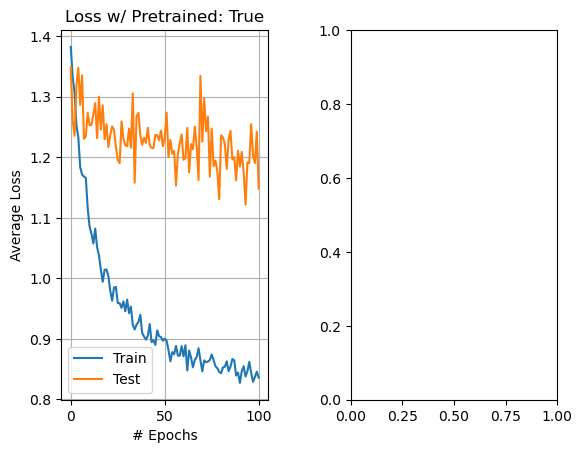

In [216]:
model=trainAndPlot()

In [230]:
def eval(model, image):
    """
    TODO: Split this into two things
    - Eval processed predict from pre-processed image to normalized lat+lon
    - Eval raw, takes a raw image procssses it, sends it to one above, then extracts real location
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    with torch.no_grad():
        x = torch.from_numpy(np.array([img.numpy()]))
        x = image.to(device)
        lossSum = 0
        nCorrect = 0
        
        yhat = model(x)
        
    return yhat

In [231]:
fun_dl = DataLoader(CampusImagesDataSet('data/test/processed', transform=allTransforms, grid_size=grid_size), batch_size=1, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


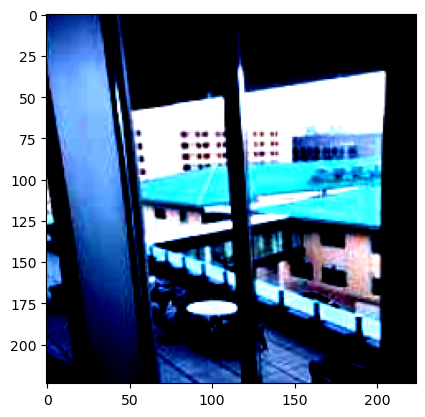

In [232]:
data_point = list(fun_dl)[5]
plot_torch_image(data_point[0][0])

In [233]:
yhat = eval(model, data_point[0])
(torch.argmax(yhat), torch.argmax(data_point[1]))

(tensor(2, device='cuda:0'), tensor(2))

In [234]:
def save_model(model, path):
    torch.save(model.state_dict(), path)
    
def load_model(path):
    model = CMUGuesserNet()
    model.load_state_dict(torch.load(path))
    model.eval()
    return model

In [235]:
save_model(model, 'model.torch')
# model = load_model('model.torch')

In [236]:
import json
import os

In [237]:
def dump_n_predictions(n, to_file):
    prediction_data = []
    for i in range(n):
        data_point = list(fun_dl)[i]
    
        yhat = eval(model, data_point[0])
        ytrue = data_point[1]

        yhat = yhat.reshape(grid_size * grid_size,).cpu()
        ytrue = ytrue.reshape(grid_size * grid_size,).cpu()

        print(torch.argmax(yhat), torch.argmax(ytrue), torch.sum(yhat), yhat)
        prediction_data.append({
            "predicted": (np.array(data.label_to_real_location(yhat))).tolist(),
            "true": list(data.labels.values())[i],
        })

    out_data = {
            "prediction_data": prediction_data,
            "grid": data.get_real_location_grid(),
        }
    with open(to_file, 'w') as f:
        json.dump(out_data, f)
    return out_data

In [238]:
pred_data = dump_n_predictions(10, 'predictions.json')
pred_data

tensor(1) tensor(0) tensor(1.0000) tensor([0.2713, 0.3284, 0.2917, 0.1085])
tensor(2) tensor(1) tensor(1.) tensor([0.1675, 0.1641, 0.3439, 0.3245])
tensor(2) tensor(0) tensor(1.) tensor([0.3327, 0.0334, 0.5143, 0.1195])
tensor(2) tensor(0) tensor(1.) tensor([0.2819, 0.0585, 0.4307, 0.2289])
tensor(2) tensor(0) tensor(1.) tensor([0.1844, 0.0915, 0.4583, 0.2658])
tensor(2) tensor(2) tensor(1.) tensor([0.1205, 0.0427, 0.6742, 0.1626])
tensor(0) tensor(2) tensor(1.) tensor([0.6267, 0.0257, 0.2422, 0.1053])
tensor(2) tensor(2) tensor(1.) tensor([0.2906, 0.0462, 0.5375, 0.1256])
tensor(0) tensor(1) tensor(1.) tensor([0.5688, 0.1415, 0.2326, 0.0572])
tensor(2) tensor(2) tensor(1.) tensor([0.1354, 0.0577, 0.5204, 0.2865])


{'prediction_data': [{'predicted': [40.44089126586914, -79.94293975830078],
   'true': [40.44152, -79.94711]},
  {'predicted': [40.44267272949219, -79.9481201171875],
   'true': [40.44211, -79.94685]},
  {'predicted': [40.44267272949219, -79.9481201171875],
   'true': [40.44327, -79.94277]},
  {'predicted': [40.44267272949219, -79.9481201171875],
   'true': [40.44386, -79.94154]},
  {'predicted': [40.44267272949219, -79.9481201171875],
   'true': [40.44326, -79.94409]},
  {'predicted': [40.44267272949219, -79.9481201171875],
   'true': [40.44261, -79.93786]},
  {'predicted': [40.44089126586914, -79.9481201171875],
   'true': [40.44277, -79.9378]},
  {'predicted': [40.44267272949219, -79.9481201171875],
   'true': [40.44251, -79.94062]},
  {'predicted': [40.44089126586914, -79.9481201171875],
   'true': [40.44386, -79.94154]},
  {'predicted': [40.44267272949219, -79.9481201171875],
   'true': [40.44166, -79.94415]}],
 'grid': [{'location': [40.44089126586914, -79.9481201171875],
   'gri

In [239]:
"""
### Evaluate on a particular test point
"""

'\n### Evaluate on a particular test point\n'

In [252]:
def plot_one_hot_vectors(vectors, labels):
    num_vectors = len(vectors)
    num_categories = len(vectors[0])
    categories = np.arange(num_categories)

    width = 0.8 / num_vectors  # Adjust the width of bars based on the number of vectors
    plt.figure()
    
    for i, vector in enumerate(vectors):
        plt.bar(categories + i * width, vector, width=width, align='center', label=labels[i])
        
    plt.xlabel('Category')
    plt.ylabel('Value')
    plt.title('One-Hot Vectors Representation')
    plt.xticks(categories + 0.4, categories)
    plt.yticks([0, 1])
    plt.legend()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


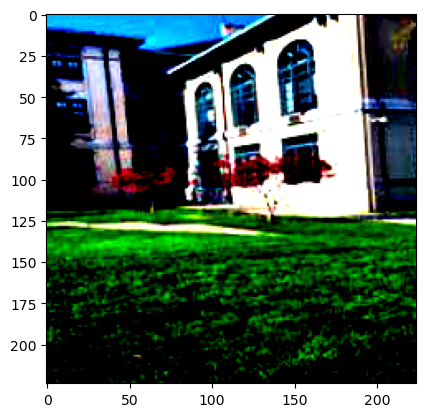

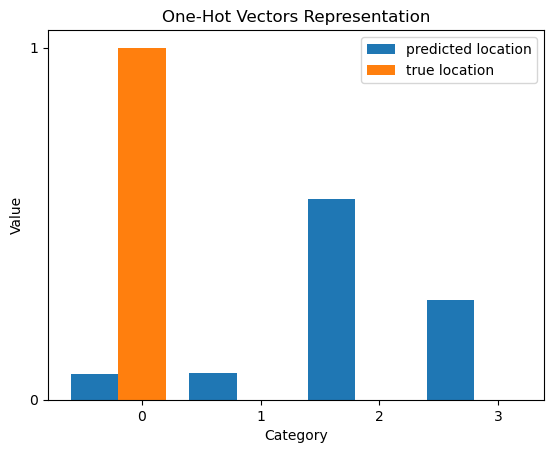

'data/test/raw/20240415_093342.jpg'

In [276]:
idx = 0
pic = list(fun_dl)[idx]
plot_torch_image(pic[0][0])
pred_loc = eval(model, data_point[0])
pred_arr = pred_loc.cpu().numpy()[0]
true_arr = pic[1].numpy()[0]
plot_one_hot_vectors([pred_arr, true_arr], ["predicted location", "true location"])
f"data/test/raw/{list(test_data.labels.keys())[idx]}"